CODE

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from skimage.segmentation import active_contour,morphological_geodesic_active_contour
from scipy import stats
import matplotlib.pyplot as plt
from skimage.segmentation import active_contour,morphological_geodesic_active_contour
from skimage.measure import label 
from skimage.morphology import medial_axis, skeletonize
from numpy.lib.function_base import disp

In [ ]:
def display_img_single(im):
  im_shape = im.shape
  ratio = im_shape[0]/im_shape[1]
  if ratio>1:
    im = cv2.resize(im, (int(max_img_disp_shape[1]/ratio),max_img_disp_shape[1]))
  else:
    im = cv2.resize(im, (max_img_disp_shape[0], int(ratio*max_img_disp_shape[0])))
  cv2_imshow(im)

In [ ]:
#This function accepts a filter f and a 2D image I and performs cross-correlation 
#and returns the result

def cross_correlation(f, I):
    # evaluates the image in valid mode
    I_nx = len(I)
    I_ny = len(I[0])
    
    f_nx = len(f)
    f_ny = len(f[0])
    
    res = np.zeros((I_nx - f_nx + 1, I_ny - f_ny + 1))
    
    for x_i in range(I_nx - f_nx + 1):
        for y_i in range(I_ny - f_ny + 1):
            i = I[x_i : x_i + f_nx, y_i : y_i + f_ny ]
            res_i = (i*f).sum()
            res[x_i,y_i] = res_i
    return res
            
#This function accepts two 2D arrays representing an image before and after a transformation.
#It normalizes the images such that the values are integer and in the range 255 and displays them

def display_img(before_img, after_img, title):
    max_before_img = before_img.max()
    min_before_img = before_img.min()
    before_img = (before_img - min_before_img)/(max_before_img - min_before_img)*255
    before_img = before_img.astype('int')
    
    max_after_img = after_img.max()
    min_after_img = after_img.min()
    after_img = (after_img - min_after_img)/(max_after_img - min_after_img)*255
    after_img = after_img.astype('int')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))
    axs[0].imshow(before_img,cmap='gray')
    axs[0].set_title('Image before {0}'.format(title))
    axs[1].imshow(after_img,cmap='gray')
    axs[1].set_title('Image after {0}'.format(title))
    
    return before_img, after_img

In [161]:
def otsu_threshold(im_in):
  inter_class_variance = np.empty(256)
  im_flat = im_in.flatten()
  im_prob = dict(zip(range(0,256), [0]*256))
  counts = np.unique(im_flat,return_counts=True)
  counts = dict(zip(counts[0], counts[1]))
  im_prob.update(counts)  
  im_prob_values = np.array(list(im_prob.values()))
  for thresh in range(1,256):
    
    class1 = im_prob_values[:thresh]
    class2 = im_prob_values[thresh:]

    class1_var = class1.var()    
    class2_var = class2.var()

    class1_sum = np.sum(class1)
    class2_sum = np.sum(class2)

    inter_class_variance[thresh] = class1_sum*class1_var + class2_sum*class2_var

  otsu_thresh = np.argmax(inter_class_variance)
  max_var = np.max(inter_class_variance)
  im_out = manual_threshold(im_in, otsu_thresh, 'otsu')

  # print('Calculated threshold through Otsu Thresholding',otsu_thresh)
  # print('Max interclass variance',max_var)
  return im_out

def manual_threshold(im_in, threshold, mode=''):
  
  im_shape = im_in.shape
  im_flat = im_in.flatten()
  im_out = (im_flat>threshold).astype('uint8')*255
  im_out = im_out.reshape(im_shape)
  return im_out


In [162]:
def preprocess_img(img_pers, bg_img , threshold = 0):

  img_abs_diff = cv2.absdiff(bg_img,img_pers)
  
  print("After subtracting the background: ")
  display_img_single(img_abs_diff)
  
  # print("Otsu Threshold result after absolute difference: ")
  if threshold == 0:
    img_abs_diff_mask = otsu_threshold(img_abs_diff)
  else:
    img_abs_diff_mask = manual_threshold(img_abs_diff,threshold)
  
  # cv2_imshow(img_abs_diff_mask)

  background = (img_abs_diff_mask!=0)*255
  img_abs_diff = (img_abs_diff_mask*img_pers + background).astype(int)
  # cv2_imshow(img_abs_diff)
  return img_abs_diff_mask

In [ ]:
def get_largest_connected_component(image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, 4, cv2.CV_32S)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    cv2.waitKey()
    return img2

In [ ]:
def get_axis_heuristics(img):
  size = img.shape
  axis = np.zeros_like(img)
  axis_points = []
  for cno in range(size[1]):
    column = img[:,cno]
    whites = np.nonzero(column>0)[0]
    if len(whites)>0:
      min_y = whites.min()
      max_y = whites.max()
      mid_y = (min_y+max_y)//2
      axis[mid_y,cno] = 255
      axis_points.append((mid_y,cno))

  return axis, axis_points

In [ ]:
def find_axis_points_from_image(im):
  nrows, ncols = im.shape
  axis_points = []
  for i_col in range(ncols):
    col = im[:,i_col]
    whites = np.nonzero(col>0)[0]
    if len(whites)>0:
      y = whites[0]
      axis_points.append(( y, i_col))
  return axis_points

In [167]:
def axis_median_filtering(im):
  
  axis_points = find_axis_points_from_image(im)
  filtered_axis_points = []
  window_size = 5
  for index  in range(window_size, len(axis_points) - window_size):
    points_set = axis_points[index-window_size:index+window_size]
    ys = [i[0] for i in points_set]
    y = int(np.median(ys))
    filtered_axis_points.append((y, axis_points[index][1]))
  
  res_im = np.zeros_like(im)
  for point in filtered_axis_points:
    res_im[point[0], point[1]] = 255
  display_img(im, res_im, "Axis Median Filtering")
  return res_im, filtered_axis_points

def find_lcc(im):
  (numLabels, labels, stats, centroids) = cv2.connectedComponentsWithStats(im, 4, cv2.CV_32S)
  max_area = 0;
  max_area_label = -1
  max_area_lcc = im.copy()

  # starting from 1 since background will the largest connected component
  for i in range(1, numLabels):
    area = stats[i, cv2.CC_STAT_AREA]

    if area > max_area:
      max_area = area
      max_area_label = i
  
  mask = np.zeros(im.shape, dtype="uint8")
  # print("[INFO] Largest connected component '{}'".format(max_area_label),max_area)
  # getting label of max area and converting it to int and binarizing it
  componentMask = (labels == max_area_label).astype("uint8") * 255
  # OR of mask (0..0) and (0..1,1,1...0)
  img_lcc_conncompmethod = cv2.bitwise_or(mask, componentMask)
  # display_img_single(im)
  # display_img_single(img_lcc_conncompmethod)
  return img_lcc_conncompmethod

def find_medial_axis(im):
  # Compute the medial axis (skeleton) and the distance transform
  skel, distance = medial_axis(im.copy(), return_distance=True)

  # Distance to the background for pixels of the skeleton
  dist_on_skel = distance * skel

  skel = skel.astype("uint8") * 255
  display_img_single(dist_on_skel)

  return dist_on_skel

def find_skeleton(im):
  bin_image = im.copy() / 255
  # perform skeletonization
  skeleton = skeletonize(bin_image)
  skeleton = skeleton.astype("uint8") * 255
  # display_img_single(skeleton)
  return skeleton

In [ ]:
def lrplot(axis_points):
  x = [i[1] for i in axis_points]
  y = [i[0] for i in axis_points]
  plt.plot(x,y)
  m, b = np.polyfit(x, y, 1)
  mx = [j*m for j in x]
  plt.plot(x, mx + b)
  plt.show()
  return m,b

from sklearn.metrics import mean_squared_error
def rmse(m, b, axis_points):
  x = [i[1] for i in axis_points]
  y_exp = [i[0] for i in axis_points]
  y_pred = [i*m +b for i in x]
  y_pred = np.array(y_pred)
  y_exp = np.array(y_exp)
  (y_pred - y_exp)
  rmse_value = mean_squared_error(y_exp, y_pred, squared=True)
  print("RMSE is : ", rmse_value)
  return rmse_value

In [166]:
def get_axis(im, method="skeletonize"):
  if method=="skeletonize":
    im_blurred = cv2.blur(im,(10,10))
    # display_img_single(im_blurred)
    img_lcc_conncompmethod = find_lcc(im_blurred)
    # display_img_single(img_lcc_conncompmethod)
    img_conn_median = cv2.medianBlur(img_lcc_conncompmethod,11)
    img_thresh_blur = cv2.blur(img_conn_median,(50,50))
    im_skeleton = find_skeleton(img_thresh_blur)
    # display_img_single(im_skeleton)
    axis_by_skletonize, axis_points_by_skeletonize = axis_median_filtering(im_skeleton)

    return axis_by_skletonize, axis_points_by_skeletonize
  else:
    axis_by_heuristics, axis_points_by_heuristics = get_axis_heuristics(im)
    return axis_by_heuristics, axis_points_by_heuristics

In [164]:
def check_pose(image, image_bg, template, template_bg, img_thresh, template_thresh):

  
  image_segmented = preprocess_img(image, image_bg, img_thresh)
  image_axis, image_axis_points = get_axis(image_segmented)
  m, b = lrplot(image_axis_points)
  image_rmse = rmse(m, b, image_axis_points)
  # cv2_imshow(image_axis)
  
  im_m = m
  
  
  template_segmented = preprocess_img(template, template_bg, template_thresh)
  template_axis, template_axis_points = get_axis(template_segmented)
  m, b = lrplot(template_axis_points)
  template_rmse = rmse(m, b, template_axis_points)
  # cv2_imshow(template_axis)
  print(f"Input Image RMSE: {image_rmse}")
  print(f"Input Image angle: {np.rad2deg(np.arctan(im_m))}")
  print(f"Template RMSE: {template_rmse}")
  print(f"Template Image angle: {np.rad2deg(np.arctan(m))}")

  return image_rmse, np.rad2deg(np.arctan(im_m)), template_rmse, np.rad2deg(np.arctan(m))


In [152]:
def rmsecheck(inp_rmse, inp_angle, template_rmse, template_angle):
  rmsediff = abs(template_rmse - inp_rmse)
  # print('Difference in rmse is : ', rmsediff)
  mdiff = abs(template_angle - inp_angle)
  # print('Difference in slope is : ', mdiff)
  if rmsediff < 500 and mdiff < 10:
    print("Correct Pose")
  else:
    print("Incorrect Pose")

Template Processing

In [153]:
max_img_disp_shape = (500,500)

In [ ]:
#Gaussian filter for denoising
gauss_f_x = np.array([[1, 3, 6, 7, 6, 3, 1]])

gauss_f_2D = np.matmul(gauss_f_x.T, gauss_f_x)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


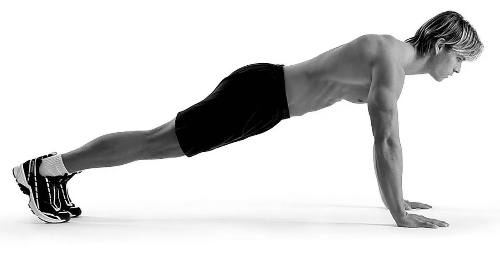

In [ ]:
template_fg = cv2.imread('/content/drive/MyDrive/CV Project/pushup_pose.jpg',0)
display_img_single(template_fg)

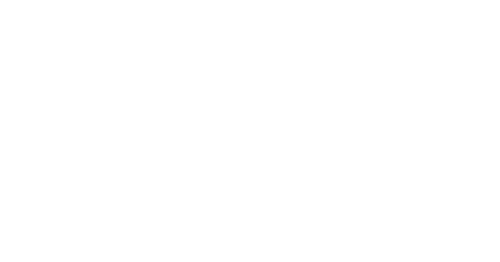

In [ ]:
template_bg = np.ones(template_fg.shape) * 255
template_bg = template_bg.astype('uint8')
display_img_single(template_bg)

In [ ]:
rr_vid = cv2.VideoCapture('/content/drive/MyDrive/CV Project/Template.mp4')
rr_vid_samples = [cv2.cvtColor(rr_vid.read()[1], cv2.COLOR_BGR2GRAY) for i in range(350)]
rr_vid_samples = np.stack(rr_vid_samples)

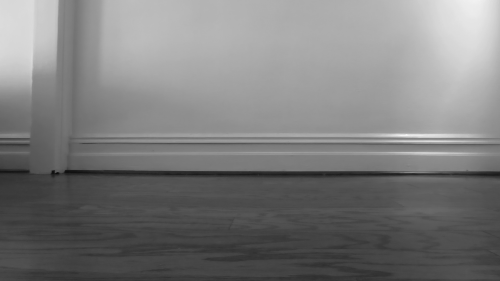

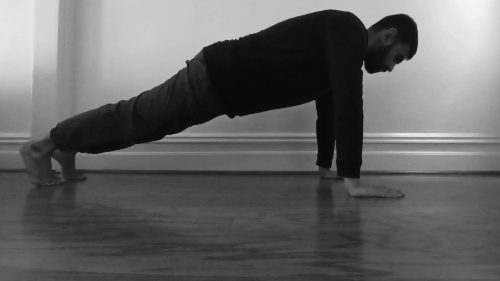

In [ ]:
rr_correct_bg = rr_vid_samples[:30].mean(axis=0).astype('uint8')
rr_correct_fg = rr_vid_samples[150]

display_img_single(rr_correct_bg)
display_img_single(rr_correct_fg)

In [ ]:
rr_inp = cv2.VideoCapture('/content/drive/MyDrive/CV Project/Input.mp4')
rr_inp_samples = [cv2.rotate(cv2.cvtColor(rr_inp.read()[1], cv2.COLOR_BGR2GRAY),cv2.ROTATE_180) for i in range(500)]
rr_inp_samples = np.stack(rr_inp_samples)

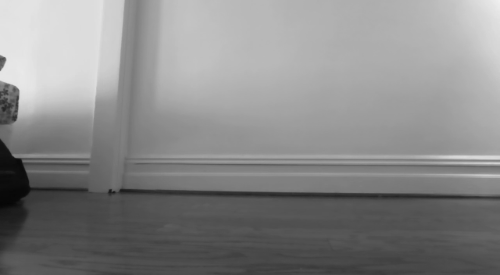

In [ ]:
rr_incorrect_bg = rr_inp_samples[0:30].mean(axis=0).astype('uint8')
display_img_single(rr_incorrect_bg)

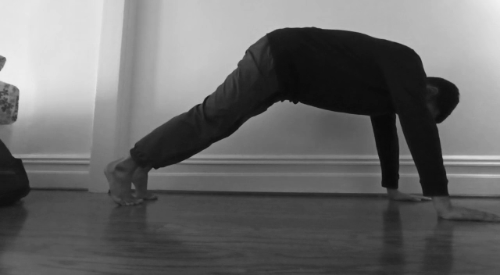

In [ ]:
rr_incorrect_fg = rr_inp_samples[400]
display_img_single(rr_incorrect_fg)

In [ ]:
ku_inp = cv2.VideoCapture('/content/drive/MyDrive/CV Project/karthikip.mp4')
ku_inp_samples = [cv2.cvtColor(ku_inp.read()[1], cv2.COLOR_BGR2GRAY) for i in range(750)]
ku_inp_samples = np.stack(ku_inp_samples)

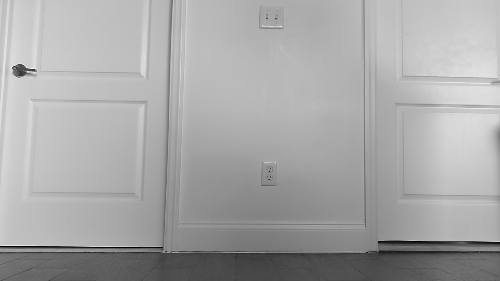

In [ ]:
ku_bg = ku_inp_samples[0:30].mean(axis=0).astype('uint8')
display_img_single(ku_bg)

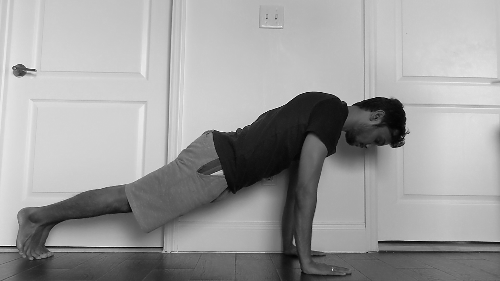

In [ ]:
ku_correct_fg = ku_inp_samples[500]
display_img_single(ku_correct_fg)

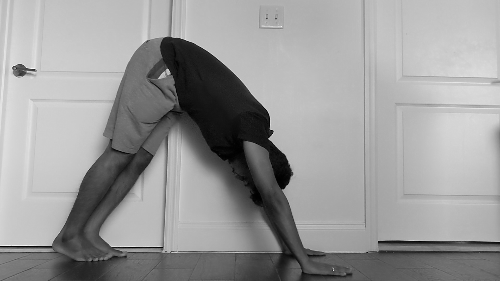

In [ ]:
ku_incorrect_fg = ku_inp_samples[700]
display_img_single(ku_incorrect_fg)

After subtracting the background: 


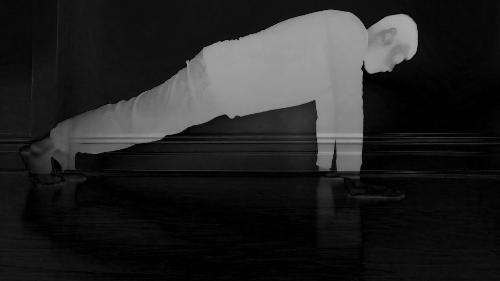

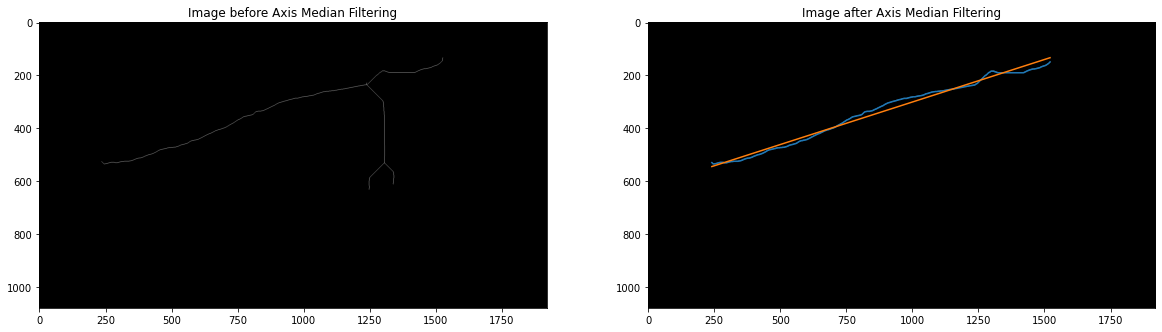

RMSE is :  203.26352070346272
After subtracting the background: 


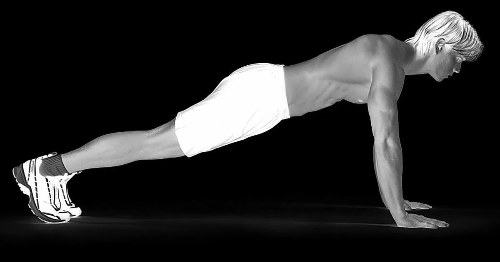

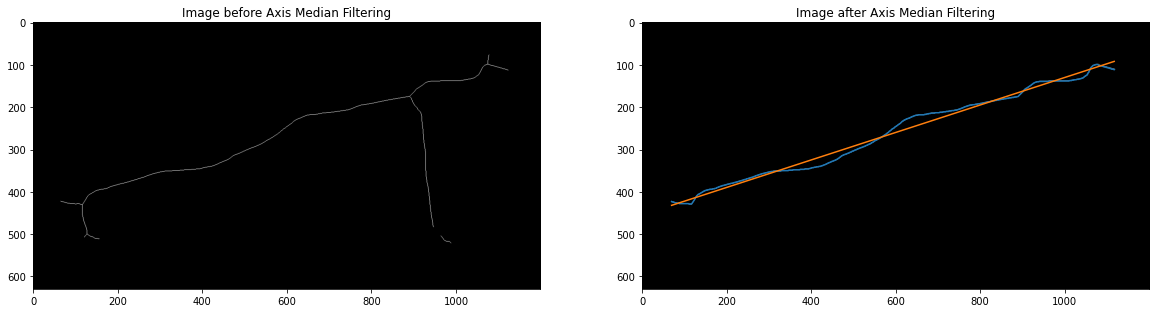

RMSE is :  124.2029749460268
Input Image RMSE: 203.26352070346272
Input Image angle: -17.84017529626599
Template RMSE: 124.2029749460268
Template Image angle: -18.015339316760283


In [168]:
rr_correct_rmse, rr_correct_angle, template_rmse, template_angle = check_pose(rr_correct_fg, rr_correct_bg, template_fg, template_bg, 65, 55)

In [ ]:
rmsecheck(rr_correct_rmse, rr_correct_angle, template_rmse, template_angle)

Correct Pose


After subtracting the background: 


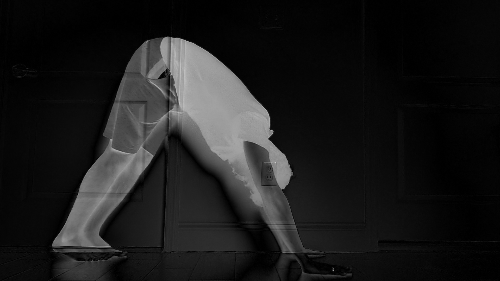

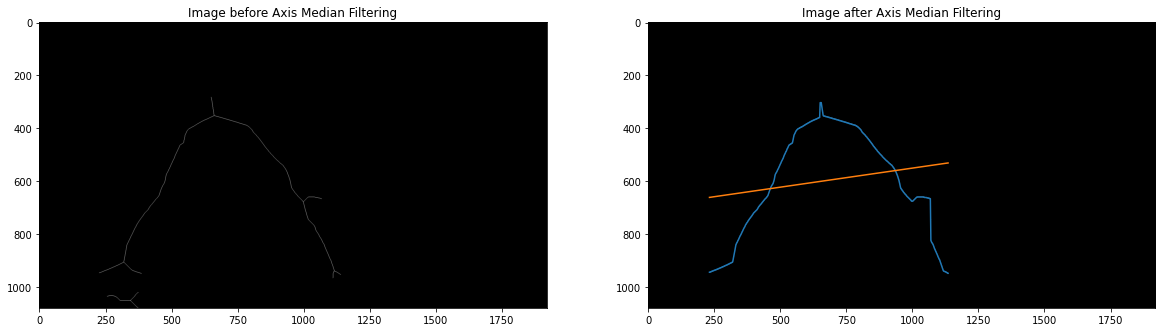

RMSE is :  37227.641802039245
After subtracting the background: 


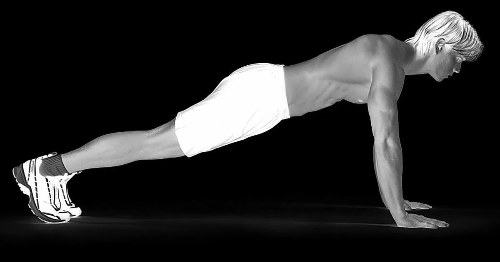

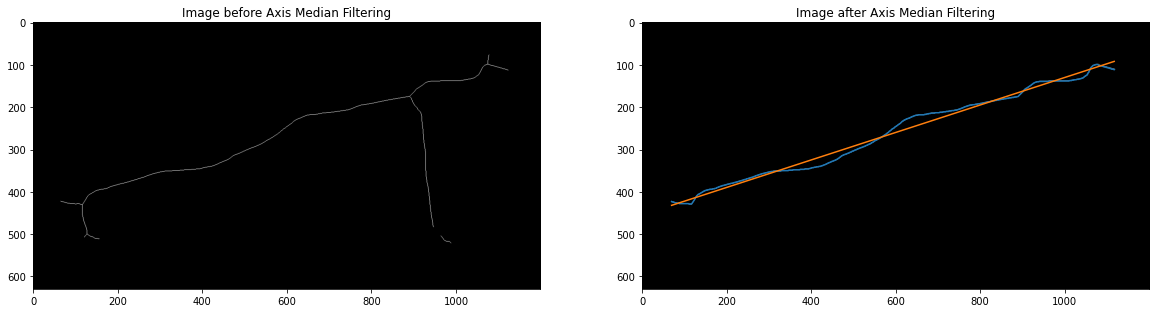

RMSE is :  124.2029749460268
Input Image RMSE: 37227.641802039245
Input Image angle: -8.215201668543896
Template RMSE: 124.2029749460268
Template Image angle: -18.015339316760283


In [170]:
ku_incorrect_rmse, ku_incorrect_angle, template_rmse, template_angle = check_pose(ku_incorrect_fg, ku_bg, template_fg, template_bg, 41, 55)

In [171]:
rmsecheck(ku_incorrect_rmse, ku_incorrect_angle, template_rmse, template_angle)

Incorrect Pose
